In [1]:
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as m
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns


Read the data
===========

In [2]:
x_original=pd.read_csv('../_xlable4_withNa_AllColumns.txt')
y_original=pd.read_csv('../_targelable4_withNa_AllColumns.txt')


x_original['max']=np.min(x_original[['FIELD_6','FIELD_7']],axis=1)
x_original=x_original.drop(columns=['FIELD_6','FIELD_7'])
x_original=x_original.query('FIELD_16 != 1 and FIELD_23 != 1')

y_original['max']=np.min(y_original[['FIELD_6','FIELD_7']],axis=1)
y_original=y_original.drop(columns=['FIELD_6','FIELD_7'])
y_original=y_original.query('FIELD_16 != 1 and FIELD_23 != 1')



In [5]:

x=x_original[['Unnamed: 0','L102900', 'L103200', 'L103300',  'L103000', 'L100800',
       'L104600', 'L100700', 'L101100', 'S000502', 'L190300', 'S000300',
       'S000501', 'L101300', 'L101700', 'L190500',
              
             'FIELD_15','FIELD_17','FIELD_22','FIELD_24','FIELD_16','FIELD_23','AGE','SEX']]

y=y_original[['Unnamed: 0','L102900']]

print(x_original.shape)
print(y_original.shape)

(159381, 407)
(159381, 407)


Prepare the data
============

In [7]:
data= pd.merge(x,y, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')
data=data.query('FIELD_15 !=1 and FIELD_17 !=1 and FIELD_22 != 1 and FIELD_24 != 1 and FIELD_16 != 1 and FIELD_23 != 1')

# data=data[data.SEX==0]
# data=data[data.AGE>=40]
data=data.dropna(). reset_index()

# data=data[data.FIELD_15!=1]
# data=data[data.FIELD_17!=1]
# data=data[data.FIELD_22!=1]
# data=data[data.FIELD_24!=1]

# data['max']=np.min(data[['FIELD_6','FIELD_7']],axis=1)
# data=data.drop(columns=['FIELD_6','FIELD_7'])
# data=data.query('FIELD_16 != 1 and FIELD_23 != 1')


print(data.shape)
data.head()

(24000, 26)


,index,Unnamed: 0,L102900_x,L103200,L103300,L103000,L100800,L104600,L100700,L101100,...,L190500,FIELD_15,FIELD_17,FIELD_22,FIELD_24,FIELD_16,FIELD_23,AGE,SEX,L102900_y
0,2,2,243.0,163.0,3.4,41.0,78.0,5.28,3.8,0.3,...,38.4,0.0,0.0,0.0,0.0,0.0,0.0,46.0,1.0,247.0
1,4,4,170.0,102.0,2.9,50.0,90.0,5.74,3.4,0.2,...,38.6,0.0,0.0,0.0,0.0,0.0,0.0,52.0,1.0,171.0
2,7,7,225.0,139.0,2.9,45.0,86.0,5.83,3.9,0.2,...,40.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,1.0,234.0
3,8,8,145.0,87.0,3.1,54.0,86.0,4.73,4.2,0.2,...,41.1,0.0,0.0,0.0,0.0,0.0,0.0,39.0,1.0,155.0
4,59,59,154.0,90.0,2.8,42.0,84.0,4.60,3.1,0.4,...,40.9,0.0,0.0,0.0,0.0,0.0,0.0,19.0,1.0,143.0


Check the correlation of the selected feature with the independent variables
=====

In [9]:
temppd=pd.DataFrame(data.copy()[['L102900_x', 'L103200', 'L103300', 'AGE', 'L103000', 'L100800',
       'L104600', 'L100700', 'L101100', 'S000502', 'L190300', 'S000300',
       'S000501', 'L101300', 'L101700', 'L190500'
                                ]]).dropna() 
temppd['y']=data.L102900_y
temppd.corr().head(20)
# corval=abs(temppd.corr()).sort_values(by='y', ascending=False)

# corr = (temppd.corr())
# sns.heatmap(corr, vmin=-1, vmax=1)

# # mask = np.zeros_like(corr)
# # mask[np.triu_indices_from(mask)] = True
# # with sns.axes_style("white"):
# #     ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)

# corr.head(20)

,L102900_x,L103200,L103300,AGE,L103000,L100800,L104600,L100700,L101100,S000502,L190300,S000300,S000501,L101300,L101700,L190500,y
L102900_x,1.000000,0.883476,0.530398,0.159350,0.304719,0.183593,0.197549,0.224616,-0.191310,0.181948,0.203499,0.220632,0.173428,0.173802,0.207375,0.223305,0.728538
L103200,0.883476,1.000000,0.560616,0.165145,-0.016393,0.089473,0.171112,0.173140,-0.114775,0.125032,0.192606,0.204925,0.126978,0.132347,0.076006,0.195616,0.645338
L103300,0.530398,0.560616,1.000000,0.180053,0.594882,0.280139,0.265608,0.405228,-0.125945,0.239470,0.384078,0.469577,0.262197,0.297243,0.243929,0.363192,0.437229
AGE,0.159350,0.165145,0.180053,1.000000,0.093490,0.206787,0.204381,0.001406,-0.033720,0.146922,-0.034655,0.098000,0.138069,0.006123,0.055483,0.043789,0.152603
L103000,0.304719,-0.016393,0.594882,0.093490,1.000000,0.352067,0.205972,0.362881,-0.170792,0.241484,0.277474,0.355196,0.250072,0.255889,0.371004,0.280317,0.258607
L100800,0.183593,0.089473,0.280139,0.206787,0.352067,1.000000,0.584240,0.196505,-0.070914,0.251752,0.199849,0.317813,0.274087,0.177461,0.239333,0.215993,0.153137
L104600,0.197549,0.171112,0.265608,0.204381,0.205972,0.584240,1.000000,0.107040,-0.152235,0.142409,0.131522,0.253323,0.148310,0.170197,0.144561,0.100232,0.176907
L100700,0.224616,0.173140,0.405228,0.001406,0.362881,0.196505,0.107040,1.000000,0.146742,0.291489,0.505041,0.422817,0.328854,0.314608,0.318213,0.516941,0.159385
L101100,-0.191310,-0.114775,-0.125945,-0.033720,-0.170792,-0.070914,-0.152235,0.146742,1.000000,0.040966,0.208896,-0.014090,0.058768,0.066149,0.053663,0.242419,-0.204120
S000502,0.181948,0.125032,0.239470,0.146922,0.241484,0.251752,0.142409,0.291489,0.040966,1.000000,0.319200,0.342282,0.760153,0.198206,0.237066,0.327712,0.138710


In [12]:
y=data[['L102900_y']]

x=data[['L102900_x', 'L103200', 'L103300', 'AGE', 'L103000', 'L100800',
       'L104600', 'L100700', 'L101100', 'S000502', 'L190300', 'S000300',
       'S000501', 'L101300', 'L101700', 'L190500']] 

Apply PCA
===========

In [13]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=8)
# pca.fit(x)

# print(pca.explained_variance_ratio_)   
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x) 
# print(x.shape)


feature scaling
=======

In [14]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# x = min_max_scaler.fit_transform(x)

clustring test
==========

In [15]:
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist

# K = range(1,10)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()


In [16]:
# kmeanModel = KMeans(n_clusters=k).fit(x)
# x['lbl']=kmeanModel.labels_ 

Random Forest Regressor
=============

In [20]:
xtrain,xtest,ytrain,ytest=train_test_split(x, y, random_state=42, test_size=0.2)

In [21]:
regr = RandomForestRegressor(max_depth=7, random_state=0,verbose =0,n_estimators=50)
regr.fit(xtrain, ytrain) 
print(regr.feature_importances_)
ypred=regr.predict(xtest)


[0.91805463 0.00611774 0.0076895  0.00624106 0.01150389 0.00476623
 0.00664082 0.00376099 0.00435527 0.00246249 0.0063489  0.00503575
 0.00348559 0.00338612 0.00376289 0.00638814]


mean_squared_error 545.0486243919847
root mean_squared_error 23.346276456685437
mean_absolute_error 17.746864471513124
r2_score 0.5202092715686435


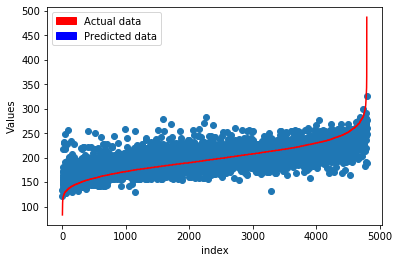

,t + 1,pred (t +1)
3435,324.0,280.339888
75,330.0,235.464079
2783,331.0,254.731773
3655,334.0,270.376565
3994,337.0,268.178501
311,342.0,326.914539
3423,343.0,189.762891
288,352.0,261.424316
2683,366.0,276.654921
346,487.0,248.829802


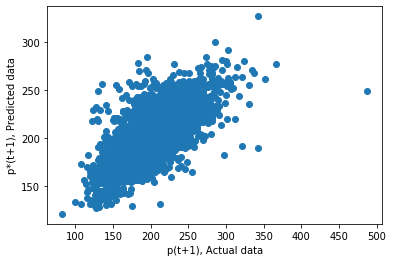

In [22]:
import math
print('mean_squared_error',m.mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(m.mean_squared_error(ytest, ypred)))
print('mean_absolute_error',m.mean_absolute_error(ytest, ypred))
print('r2_score',m.r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.tail(10)

xg boost
==========

In [23]:
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',max_depth = 10, alpha = 200, n_estimators = 50, 
                          booster='gbtree',
                          colsample_bytree = 0.6,learning_rate = 0.08,gamma=10, tree_method = 'gpu_hist'
                         )

xg_reg.fit(xtrain, ytrain) 

XGBRegressor(alpha=200, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=10,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [24]:

ypred = xg_reg.predict(xtest)
 
print('mean_squared_error',m.mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(m.mean_squared_error(ytest, ypred)))
print('mean_absolute_error',m.mean_absolute_error(ytest, ypred))
print('r2_score',m.r2_score(ytest, ypred))


mean_squared_error 552.4514936727512
root mean_squared_error 23.504286708444297
mean_absolute_error 17.870393713315327
r2_score 0.5136927372894069


ANN
==========

In [ ]:
model= Sequential()
model.add(Dense(input_dim=32,units=128,activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=16, activation='relu', kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=8, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, kernel_initializer='uniform'))
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error' ])

In [ ]:
h=model.fit(xtrain, ytrain, validation_split=.2,epochs=100, batch_size=50)

In [ ]:
ypred=model.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

In [ ]:
history=h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
ypredPD['diff']=abs(ypredPD['t + 1']- ypredPD['pred (t +1)'])
print(np.mean(ypredPD['diff']))
print(np.std(ypredPD['diff']))
print(100*ypredPD[ypredPD['diff']<=5].shape[0]/ypredPD.shape[0])

In [ ]:

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.head(10)

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)